In [6]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa

import show, utils

print(f"tensorflow: {tf.__version__}")
print("Available devices:", *[d.name for d in tf.config.list_physical_devices()])

ModuleNotFoundError: ignored

In [2]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 37.7 MB/s eta 0:00:00


#### Parameters

In [7]:
DATASET_PATH = "/content/drive/MyDrive/dataset"
IMG_SIZE = 224
SEED = 42
EPOCHS = 15

DATA_AUG_PARAMS = {
    'BRIGHTNESS': 0.5,
    'HUE': 0.5,
    'CONTRAST_MIN': 0.5,
    'CONTRAST_MAX': 1.5,
    'SATURATION_MIN': 0.5,
    'SATURATION_MAX': 1.5,
    'ZOOM_FACTOR': 0.5,
    'ROTATION_FACTOR': 0.2
}

#### Set Random Seed

In [8]:
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#### Create Datasets with Data Augmentation

In [9]:
train_dataset = keras.preprocessing.image_dataset_from_directory(os.path.join(DATASET_PATH, "Training_Data"), image_size=(IMG_SIZE, IMG_SIZE), batch_size=None, shuffle=True)
valid_dataset = keras.preprocessing.image_dataset_from_directory(os.path.join(DATASET_PATH, "Testing_Data"), image_size=(IMG_SIZE, IMG_SIZE), batch_size=None, shuffle=False)

print(valid_dataset)

for image, image_label in train_dataset.take(4):
    plt.figure()
    plt.imshow(image / 255.)
    plt.title(f"class={image_label}")

NotFoundError: ignored

In [ ]:
random_zoom = keras.layers.RandomZoom(DATA_AUG_PARAMS['ZOOM_FACTOR'])
random_rotation = keras.layers.RandomRotation(DATA_AUG_PARAMS['ROTATION_FACTOR'])

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img = list(train_dataset.take(1).batch(1))[0][0] / 255.

# random zoom
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Random zoom')
ax[0].imshow(img[0])
for i in range(1, 5):
    ax[i].imshow(random_zoom(img)[0])

# random rotation
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Random rotation')
ax[0].imshow(img[0])
for i in range(1, 5):
    ax[i].imshow(random_rotation(img)[0])

# random flip left right
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Random flip left right')
ax[0].imshow(img[0])
for i in range(1, 5):
    ax[i].imshow(tf.image.random_flip_left_right(img)[0])

# random brightness
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Random brightness')
ax[0].imshow(img[0])
for i in range(1, 5):
    ax[i].imshow(tf.image.random_brightness(img, DATA_AUG_PARAMS['BRIGHTNESS'])[0])

# random contrast
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Random contrast')
ax[0].imshow(img[0])
for i in range(1, 5):
    ax[i].imshow(tf.image.random_contrast(img, DATA_AUG_PARAMS['CONTRAST_MIN'], DATA_AUG_PARAMS['CONTRAST_MAX'])[0])

# random hue
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Random hue')
ax[0].imshow(img[0])
for i in range(1, 5):
    ax[i].imshow(tf.image.random_hue(img, DATA_AUG_PARAMS['HUE'])[0])

# random saturation
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Random saturation')
ax[0].imshow(img[0])
for i in range(1, 5):
    ax[i].imshow(tf.image.random_saturation(img, DATA_AUG_PARAMS['SATURATION_MIN'], DATA_AUG_PARAMS['SATURATION_MAX'])[0])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ds_train = (
    train_dataset
    .map(lambda x, y: (x / 255., y))
    .map(lambda x, y: (random_zoom(x), y))
    .map(lambda x, y: (random_rotation(x), y))
    .map(lambda x, y: (tf.image.random_flip_left_right(x), y))
    .map(lambda x, y: (tf.image.random_brightness(x, DATA_AUG_PARAMS['BRIGHTNESS']), y))
    .map(lambda x, y: (tf.image.random_contrast(x, DATA_AUG_PARAMS['CONTRAST_MIN'], DATA_AUG_PARAMS['CONTRAST_MAX']), y))
    .map(lambda x, y: (tf.image.random_hue(x, DATA_AUG_PARAMS['HUE']), y))
    .map(lambda x, y: (tf.image.random_saturation(x, DATA_AUG_PARAMS['SATURATION_MIN'], DATA_AUG_PARAMS['SATURATION_MAX']), y))
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

ds_valid = (
    valid_dataset
    .map(lambda x, y: (x / 255., y))
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
show.show_images_from_dataset(ds_train, 4, figsize=(10, 10))

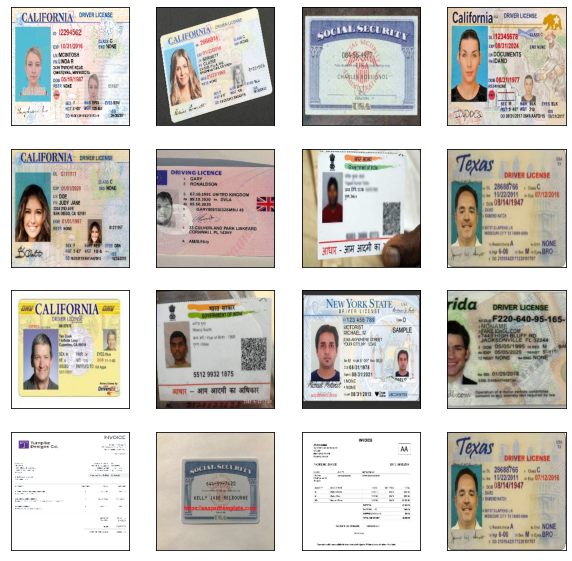

In [ ]:
show.show_images_from_dataset(ds_valid.unbatch().shuffle(1024).batch(32), 4, figsize=(10, 10))

#### Build Model

In [ ]:
keras.backend.clear_session()
cnn = keras.applications.MobileNetV2(include_top=False, pooling='avg', input_shape=(224, 224, 3))
cnn.trainable = True
cnn = keras.Sequential([
    cnn,
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Lambda(lambda x: keras.backend.l2_normalize(x, axis=-1))
])
cnn.compile(loss=tfa.losses.TripletHardLoss(), optimizer=keras.optimizers.Adam(1e-5))

#### Train

Text(0, 0.5, 'Learning rate')

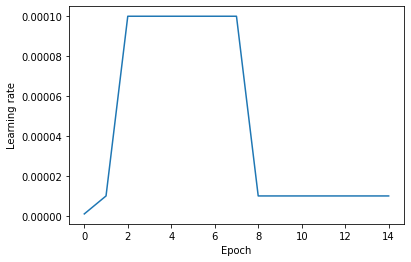

In [ ]:
def schedule_fn(epoch, lr):
    #s = {0: 1e-6, 1: 1e-5, 2: 1e-4, 15: 1e-5}
    s = {0: 1e-6, 1: 1e-5, 2: 1e-4, 8: 1e-5}

    if epoch in s.keys():
        return s[epoch]
    return lr


lr = None
lr_list = list()
for epoch in range(EPOCHS):
    lr = schedule_fn(epoch, lr)
    lr_list.append(lr)


plt.plot(lr_list)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')

In [ ]:
callbacks = [keras.callbacks.LearningRateScheduler(schedule_fn)]

h = cnn.fit(ds_train, validation_data=ds_valid, callbacks=callbacks, epochs=EPOCHS, verbose=2)

Epoch 1/15
38/38 - 43s - loss: 1.1481 - val_loss: 1.0450 - lr: 1.0000e-06 - 43s/epoch - 1s/step
Epoch 2/15
38/38 - 25s - loss: 1.1366 - val_loss: 1.0445 - lr: 1.0000e-05 - 25s/epoch - 655ms/step
Epoch 3/15
38/38 - 25s - loss: 1.0792 - val_loss: 1.0162 - lr: 1.0000e-04 - 25s/epoch - 665ms/step
Epoch 4/15
38/38 - 25s - loss: 0.9130 - val_loss: 0.9873 - lr: 1.0000e-04 - 25s/epoch - 663ms/step
Epoch 5/15
38/38 - 25s - loss: 0.6411 - val_loss: 1.0014 - lr: 1.0000e-04 - 25s/epoch - 661ms/step
Epoch 6/15
38/38 - 25s - loss: 0.4081 - val_loss: 0.9254 - lr: 1.0000e-04 - 25s/epoch - 660ms/step
Epoch 7/15
38/38 - 25s - loss: 0.2101 - val_loss: 0.9605 - lr: 1.0000e-04 - 25s/epoch - 660ms/step
Epoch 8/15
38/38 - 25s - loss: 0.1926 - val_loss: 0.9135 - lr: 1.0000e-04 - 25s/epoch - 661ms/step
Epoch 9/15
38/38 - 25s - loss: 0.1736 - val_loss: 0.8865 - lr: 1.0000e-05 - 25s/epoch - 662ms/step
Epoch 10/15
38/38 - 25s - loss: 0.2683 - val_loss: 0.8839 - lr: 1.0000e-05 - 25s/epoch - 663ms/step
Epoch 11/15


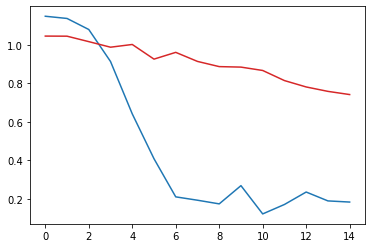

In [ ]:
plt.plot(h.history['loss'], color='tab:blue')
plt.plot(h.history['val_loss'], color='tab:red')

#### Predictions

In [ ]:
imgs = np.concatenate([xb for xb, yb in ds_valid], axis=0)
embeddings = cnn.predict(ds_valid)

5/5 [==============================] - 2s 177ms/step


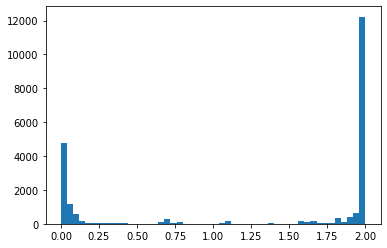

In [ ]:
d2 = utils.get_squared_distance_matrix(embeddings, diag_value=np.inf)
d2_flatten = np.ravel(d2)
plt.hist(d2_flatten[d2_flatten < np.inf], 50);

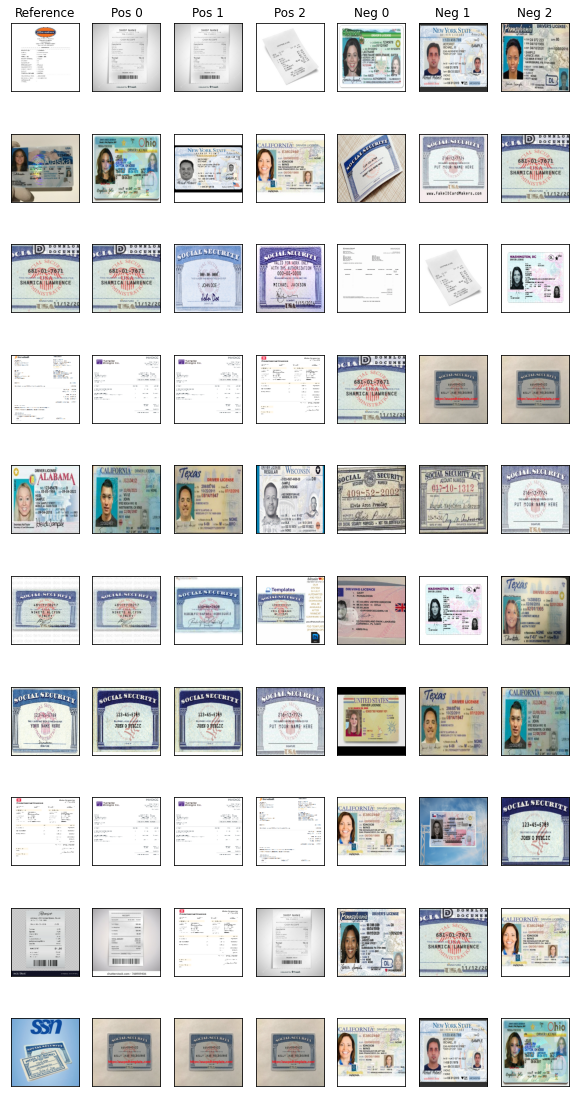

In [ ]:
show.show_similar_images(imgs, d2, num_images=10, num_pos=3, num_neg=3, figsize=(10, 20))